# Introduction to PIASO
Precise Intregrative Analysis of Single-cell Omics

## Installing PIASO

Navigate to the directory where you want to install PIASO and clone the PIASO github repository to your local directory. Then, install PIASO using setup.py

```
cd <directory_path>
git clone https://github.com/genecell/PIASO.git
cd PIASO
python setup.py install --prefix <directory_path>/PIASO
```

## Import Required Packages

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
from typing import Iterable, Union, Optional
import matplotlib.pyplot as plt
import anndata as ad
import logging
from matplotlib import rcParams
import seaborn as sns
from matplotlib import cm
from matplotlib import colors, colorbar

In [ ]:
# path = '/data1/vallaris/Analysis/Python/Packages/PIASO'
# import sys
# sys.path.append(path)
import piaso

In [ ]:
sys.path

## Setting Figure Parameters

In [ ]:
sc.set_figure_params(dpi=80,dpi_save=300, color_map='viridis',facecolor='white')
rcParams['figure.figsize'] = 5, 5
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"
sc.settings.verbosity = 3
sc.logging.print_header()

In [ ]:
cmap_own = plt.get_cmap('magma_r', 256)
newcolors = cmap_own(np.linspace(0,0.75 , 256))
Greys = plt.get_cmap('Greys_r', 256)
newcolors[:10, :] = Greys(np.linspace(0.8125, 0.8725, 10))
pos_cmap = colors.ListedColormap(newcolors)
di_cmap=sns.diverging_palette(138,359,s=72,l=50,sep=27,n=15,as_cmap=True)

### Setting paths to save results - do we have to include this?

In [ ]:
save_dir = '/data1/vallaris/Results/single-cell/PIASO'
sc.settings.figdir = save_dir
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Loading the data

Let us load a 20k subsampled version of the Seattle Alzheimer’s Disease Brain Cell Atlas (SEA-AD) project dataset described in detail in Gabitto et. al. (2024). We will be using the scRNA-seq data from the dataset in this tutorial. 

For more details about the data, refer to:

Gabitto, M.I., Travaglini, K.J., Rachleff, V.M. et al. Integrated multimodal cell atlas of Alzheimer’s disease. Nat Neurosci 27, 2366–2383 (2024). https://doi.org/10.1038/s41593-024-01774-5

Download the subsampled dataset from Google Drive: https://drive.google.com/file/d/1nH-CRaTQFxJ5pAVpy8_hUQn1nrIcakq2/view?usp=drive_link

The original data is available on https://portal.brain-map.org/explore/seattle-alzheimers-disease

In [ ]:
!/home/vas744/Software/gdrive files download --destination /home/vas744/Data/Public/PIASO 1nH-CRaTQFxJ5pAVpy8_hUQn1nrIcakq2

In [ ]:
adata=sc.read('/data1/vallaris/Analysis/Python/Packages/PIASO_Testing/SEA-AD_RNA_MTG_subsample_excludeReference_20k_piaso.h5ad')
adata

This data has been pre-processed already. But for the purposes of this tutorial, we will start again with the counts data and go through the normalization and other pre-processing steps.

In [ ]:
adata.X=adata.layers['UMIs'].copy()

Now we filter out cells with less than 200 genes. You can also filter out genes that are lowly expressed in cells.

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)

Identify and annotate the mitochondrial genes in the data and compute their quality control metrics.

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Identify and annotate the ribosomal protein genes in the data and compute the percenatge of total genes that are ribosomal protein genes.

In [ ]:
ribo_cells = adata.var_names.str.startswith('RPS','RPL')
adata.obs['pct_counts_ribo'] = np.ravel(100*np.sum(adata[:, ribo_cells].X, axis = 1) / np.sum(adata.X, axis = 1))

Visualize the metrics for all genes, and mitochondrial and ribosomal protein genes in a violin plot.

The levels of these genes can be used to eliminate low-quality cells. Higher percentage if mt or ribo genes in a cell implies a lysed cell prior to mRNA capture.

In [ ]:
piaso.pl.plot_features_violin(adata,
                              ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
                              groupby='Subclass')

## Normalization

Normalize each cell with the total counts over all the genes, and then logarithmize the data.

In [ ]:
adata.layers['raw']=adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.layers['log1p']=adata.X

Now, we perform feature selection to reduce the number of fearures (genes) used as input for further downstream processing. Here, we select the top 3000 highly variable genes.

RNA-seq data is usually overdispersed, i.e. variance exceeds the mean. Therefore, we normalize such data by adjusting for overdispersion using Pearson residuals derived from the fitted negative binomial model.

**Note**: Since we aren't filtering any genes here, there might be some genes which don't express in any cell and therefore lead to columns with all zeros. This is the reason for the RuntimeWarning: invalid value encountered in divide residuals = diff / np.sqrt(mu + mu**2 / theta). But this will not affect our analysis, since we will be using the log1p layer instead of the raw layer.

In [ ]:
sc.experimental.pp.highly_variable_genes(adata,
                                         layer='raw',
                                         n_top_genes=3000)

pr_offset=sc.experimental.pp.normalize_pearson_residuals(adata,
                                                         layer='raw',
                                                         inplace=False)

adata.X=pr_offset['X']

del pr_offset

## Visualization with UMAPs

Again, since the data has been pre-processed, we have the umap computation given by the authors in the AnnData object, but for the purposes of this tutorial, we will backup that umap, and re-compute again.

In [ ]:
adata.obsm['X_umap_backup']=adata.obsm['X_umap'].copy()

In [ ]:
piaso.tools.runSVD(adata,
                   use_highly_variable=True,
                   n_components=50,
                   random_state=10, 
                   key_added='X_svd')

In [ ]:
%%time
sc.pp.neighbors(adata,
                use_rep='X_svd',
                n_neighbors=15,
                random_state=10,
                knn=True,
                method="umap")
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata,
           color=['Subclass'],
           palette=piaso.pl.color.d_color4,
           cmap=pos_cmap,
           size=10,
           frameon=True)

Backup the umap computation based on the raw data.

In [ ]:
adata.obsm['X_umap_raw']=adata.obsm['X_umap'].copy()

Visualize the overall as well as mitochondrial and ribosomal protein gene expression.

In [ ]:
sc.pl.umap(adata,
           color=['n_genes_by_counts', 'total_counts','pct_counts_mt','pct_counts_ribo'],
           cmap='Spectral_r',
           palette=piaso.pl.color.d_color4,
           ncols=4,
           size=10,
           frameon=False,)

In [ ]:
sc.set_figure_params(dpi=300,dpi_save=300, color_map='viridis',facecolor='white')
sc.pl.umap(adata,
           color=['n_genes_by_counts', 'total_counts','pct_counts_mt','pct_counts_ribo'],
           cmap='Spectral_r',
           palette=piaso.pl.color.d_color4,
           ncols=4,
           size=10,
           frameon=False,)
sc.set_figure_params(dpi=80,dpi_save=300, color_map='viridis',facecolor='white')

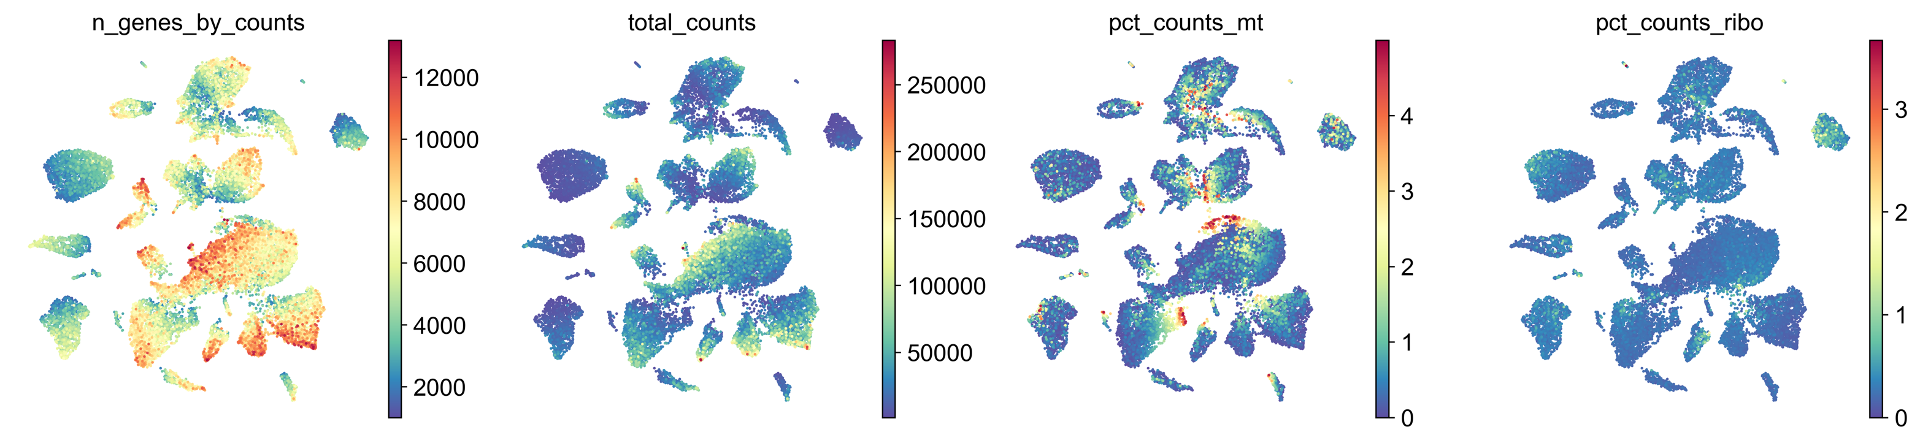

## Clustering the data
run clustering on selected cluster(s): use the leiden_local function in the tutorial

In [ ]:
%%time
sc.tl.leiden(adata,resolution=0.5,key_added='Leiden',flavor="leidenalg",n_iterations=-1)

In [ ]:
logging.getLogger('matplotlib.font_manager').disabled = True

In [ ]:
sc.pl.umap(adata,
           color=['Leiden'],
           palette=piaso.pl.color.d_color4,
           cmap=pos_cmap,
           legend_fontsize=12,
           legend_fontoutline=2,
           legend_loc='on data',
           size=10,
           frameon=False)

## Marker Gene Identification for each cluster

In this workflow, you might want to identify marker genes for each cluster. This can be done using cosg (Dai et al., (2022)), which is a python package you can install in your environment by running:

```
pip install cosg
```
For more details about cosg, please refer to: 

https://github.com/genecell/COSG

Min Dai, Xiaobing Pei, Xiu-Jie Wang, Accurate and fast cell marker gene identification with COSG, Briefings in Bioinformatics, Volume 23, Issue 2, March 2022, bbab579, https://doi.org/10.1093/bib/bbab579

In [ ]:
import cosg
n_gene=30
cosg.cosg(adata,
          key_added='cosg',
          use_raw=False,
          layer='log1p', ## e.g., if you want to use the log1p layer in adata
          mu=100,
          expressed_pct=0.1,
          remove_lowly_expressed=True,
          n_genes_user=100,
          groupby='Leiden')

In [ ]:
sc.tl.dendrogram(adata,groupby='Leiden',use_rep='X_svd')
df_tmp=pd.DataFrame(adata.uns['cosg']['names'][:3,]).T
df_tmp=df_tmp.reindex(adata.uns['dendrogram_'+'Leiden']['categories_ordered'])
marker_genes_list={idx: list(row.values) for idx, row in df_tmp.iterrows()}
marker_genes_list = {k: v for k, v in marker_genes_list.items() if not any(isinstance(x, float) for x in v)}

sc.pl.dotplot(adata,
              marker_genes_list,
              groupby='Leiden',
              layer='log1p',
              dendrogram=True,
              swap_axes=True,
              standard_scale='var',
              cmap='Spectral_r')

In [ ]:
sc.tl.dendrogram(adata,groupby='Leiden',use_rep='X_svd')
df_tmp=pd.DataFrame(adata.uns['cosg']['names'][:3,]).T
df_tmp=df_tmp.reindex(adata.uns['dendrogram_'+'Leiden']['categories_ordered'])
marker_genes_list={idx: list(row.values) for idx, row in df_tmp.iterrows()}
marker_genes_list = {k: v for k, v in marker_genes_list.items() if not any(isinstance(x, float) for x in v)}

sc.pl.dotplot(adata,
              marker_genes_list,
              groupby='Leiden',
              layer='log1p',
              dendrogram=True,
              swap_axes=True,
              standard_scale='var',
              cmap='Spectral_r',
              figsize=[10,20])

In [ ]:
marker_gene=pd.DataFrame(adata.uns['cosg']['names'])

sc.pl.umap(adata,
           color=['Leiden'],
           palette=piaso.pl.color.d_color4,
           cmap=pos_cmap,
           legend_fontsize=12,
           legend_fontoutline=2,
           legend_loc='on data',
           size=10,
           frameon=False)

## Gene-guided Dimensionality Reduction (GDR)

GDR is an alternative dimensionality reduction method by projecting cells into a low-dimensional gene expression space that reflects biological identity in each dimension. Here we will demonstrate how PIASO's runGDR can be used instead of SVD for dimensionality reduction.

For more details about GDR and it's applications, please refer to:
https://www.biorxiv.org/content/10.1101/2024.07.20.604399v1


In [ ]:
adata.obsm['X_umap_svd']=adata.obsm['X_umap'].copy()

In [ ]:
piaso.tl.runGDR(adata,
                batch_key=None,
                groupby='Leiden',
                n_gene=30,
                mu=1.0,
                use_highly_variable=True,
                n_highly_variable_genes=5000,
                layer='log1p',
                score_layer='log1p',
                n_svd_dims=50,
                resolution=1.0,
                scoring_method=None,
                key_added='X_gdr',
                verbosity=0)

In [ ]:
%%time
sc.pp.neighbors(adata,
                use_rep='X_gdr',
                n_neighbors=15,
                random_state=10,
                knn=True,
                method="umap")
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata,
           color=['Subclass'],
           palette=piaso.pl.color.d_color4,
           cmap=pos_cmap,
           ncols=3,
           size=10,
           frameon=True)

## Predict Cell Type by GDR (Gene-guided Dimensionality Reduction)
Gene-guided Dimensionality Reduction - Do we add more description about the method and what it is doing?

Since we have the subclasses of the cells in this dataset, we can use a part of this data as reference to "predict" the cell types of the remaining data.

Let us do a stratified 80:20 split of the data. The 80% data can be the reference dataset which will be used to train the model in predictCellTypeByGDR, and then predict the subclasses for the remaining 20% data.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
X = adata.X.copy()
y = adata.obs["Subclass"].values

stratified_split.get_n_splits(X, y)
for i, (train_index, test_index) in enumerate(stratified_split.split(X, y)):
    adata_ref = adata[train_index].copy()
    adata_test = adata[test_index].copy()

In [ ]:
piaso.tl.predictCellTypeByGDR(
    adata_test,
    adata_ref,
    layer = 'log1p',
    layer_reference = 'log1p',
    reference_groupby  = 'Subclass',
    query_groupby = 'Leiden',
    mu = 10.0,
    n_genes= 15,
    return_integration = False,
    use_highly_variable = True,
    n_highly_variable_genes = 5000,
    n_svd_dims = 50,
    resolution= 1.0,
    scoring_method= None,
    key_added= None,
    verbosity= 0,
)

In [ ]:
adata_test.obs['CellTypes_gdr']

We can now visualize the subclasses predicted by the predictCellTypeByGDR method.

In [ ]:
# FIX THE COLORS
adata_test.obs['CellTypes_gdr']=adata_test.obs['CellTypes_gdr'].astype('category')
adata_test.obs['CellTypes_gdr']=adata_test.obs['CellTypes_gdr'].cat.reorder_categories(adata_ref.obs['Subclass'].cat.categories)

# adata_test.obs['CellTypes_gdr_colors'].cat.reorder_categories(adata_ref.obs['Subclass_colors'].cat.categories,ordered=True)

In [ ]:
adata_test.obs['CellTypes_gdr'].cat.categories

In [ ]:
adata_ref.obs['Subclass'].cat.categories

In [ ]:
sc.pl.embedding(adata_test,
                basis='X_umap',
                color=['CellTypes_gdr'],
                palette=piaso.pl.color.d_color4,
                cmap=piaso.pl.color.c_color3,
                ncols=3,
                size=10,
                frameon=False)

We can compare these predicted subclasses with the actual subclasses by plotting adata_test with the actual Subclass values.

In [ ]:
sc.pl.embedding(adata_test,
                basis='X_umap',
                color=['Subclass'],
                palette=piaso.pl.color.d_color4,
                cmap=piaso.pl.color.c_color3,
                ncols=3,
                size=10,
                frameon=False)

Since we know the real subclass of the test data, we can test the performance of predictCellTypeByGDR by comparing predicted celltypes and true subclasses.

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y[test_index], adata_test.obs['CellTypes_gdr'].values)

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix, columns=adata_test.obs['Subclass'].cat.categories, index=adata_test.obs['Subclass'].cat.categories)
normalized_cf_matrix_df = (confusion_matrix_df - confusion_matrix_df.mean(axis=0))/confusion_matrix_df.std(axis=0)

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set(rc={'figure.figsize':(10, 6)})
sns.heatmap(normalized_cf_matrix_df,
            cmap="YlGnBu",
            xticklabels=True,
            yticklabels=True)
plt.show()